# La Tinka: Análisis de Datos y Modelado de Probabilidades

**Descripción:**  

Este análisis explora datos históricos de la lotería *La Tinka* con el objetivo de identificar patrones y hallazgos relevantes.  
La meta es diseñar estrategias de selección de números basadas en análisis de datos y comparar la probabilidad de ganar **antes** y **después** de aplicar estas reglas, usando una simulación de Montecarlo.

**Nota:** Aunque estos análisis no garantizan aumentar la probabilidad de ganar —el juego sigue siendo de azar—, pueden ayudar a detectar posibles **sesgos o patrones históricos** que sirvan como referencia.

---

In [77]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
# Librerías
import pandas as pd
from analysis_utils import choose_random_numbers, simulate_tinka, plot_numbers, monte_carlo_tinka, analyze_number_frequency, hot_and_cold_numbers, analyze_even_odd, analyze_low_high, analyze_repeated_sequences, analyze_consecutive_numbers, analyze_transitions, analyze_number_frequency_highlight, analyze_repeats, analyze_ball_position_ranges, analyze_optimal_ranges_per_position, plot_histograms_per_position
import warnings
warnings.filterwarnings("ignore")

## 1. Conociendo el Juego: Jugando La Tinka

**Descripción:**

En esta sección se explican las reglas de *La Tinka* y se realizan simulaciones de jugadas aleatorias sin aplicar ninguna lógica.  
El objetivo es establecer una **probabilidad base** de ganar cuando los números se eligen completamente al azar.

---

#### ¿Qué es la Tinka?
**La Tinka** es un juego de lotería en Perú en el que los participantes seleccionan **6 números** diferentes dentro de un rango del **1 al 50**.  
En cada sorteo también se extrae un **séptimo número especial**, llamado **Boliyapa**.

---

#### Reglas del juego
1. **Selección de números**  
   - El jugador elige **6 números únicos** (puede pagar extra para elegir más de 6).
   - El rango permitido es **del 1 al 50**.

2. **Sorteo oficial**  
   - Se extraen **6 bolas principales** (orden no importa).  
   - Luego se extrae la **Boliyapa** (bola adicional).

3. **Cálculo de aciertos**  
   - Se compara la selección del jugador con los **6 números principales**.
   - Si se incluye la Boliyapa, esta puede aumentar la cantidad de aciertos dependiendo de las reglas del premio.

---

#### Premios (esquema general)
- **6 aciertos** → Premio mayor (*pozo millonario*).  
- **5 aciertos + Boliyapa** → Premio secundario alto.  
- **5 aciertos** → Premio importante.  
- **4, 3 o 2 aciertos** → Premios menores o reintegros.

> 💡 Los premios exactos y condiciones pueden variar según el reglamento oficial vigente. *www.latinka.com.pe*

---

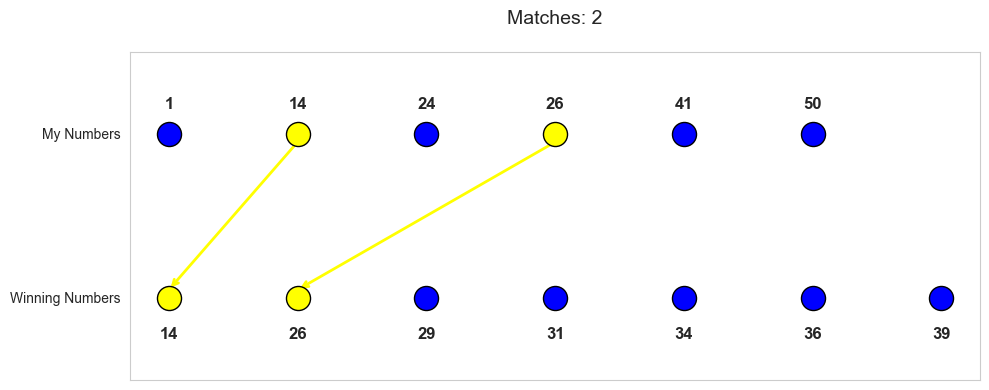

In [79]:
# Simulación de Tinka
my_numbers = choose_random_numbers(6) # Números del jugador (En este caso aleatorios)
winning_numbers = simulate_tinka(include_boliyapa=True)  # Números ganadores con boliyapa

plot_numbers(my_numbers, winning_numbers) 

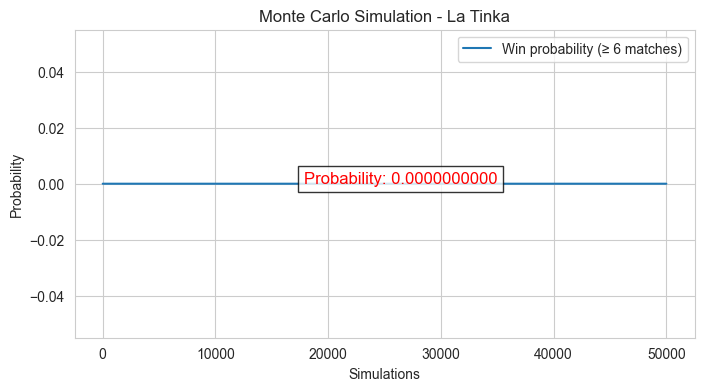

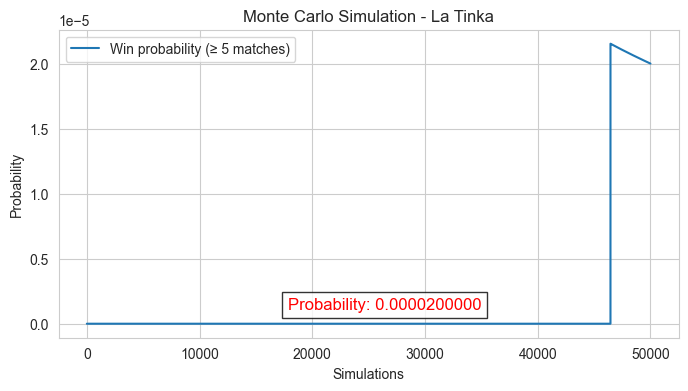

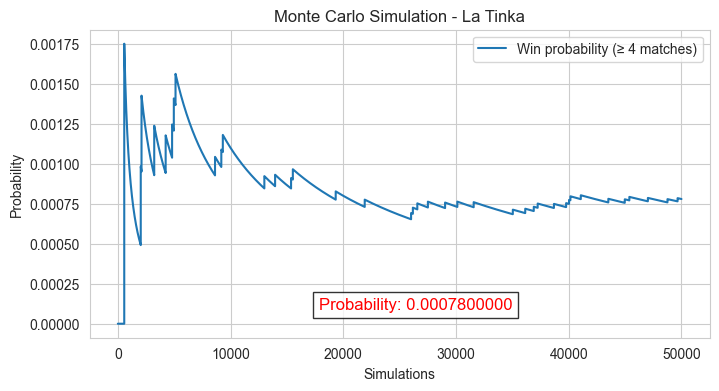

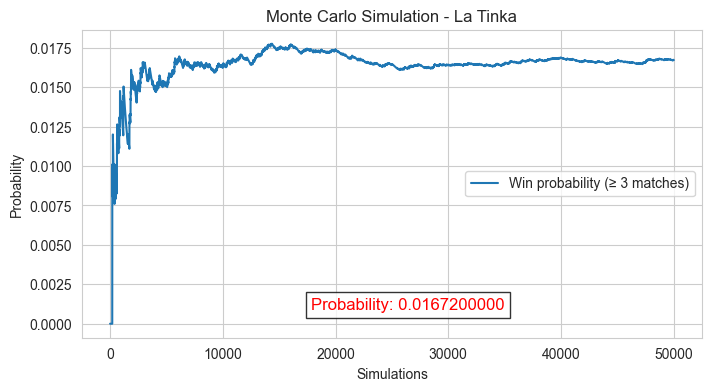

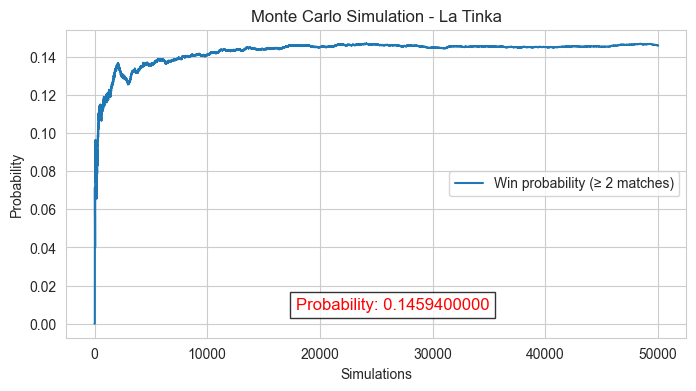

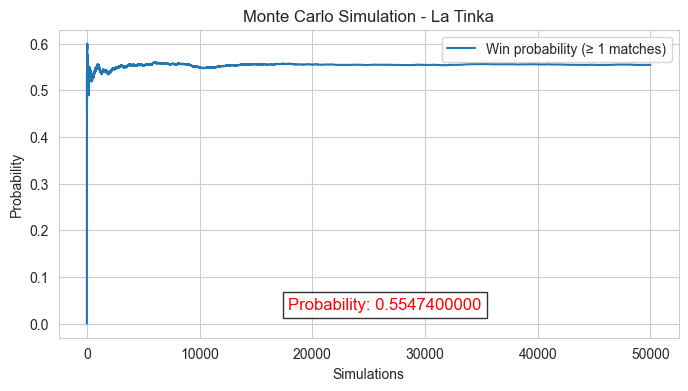

In [96]:
monte_carlo_tinka(choose_random_numbers(), wins_needed=6, simulations=50000)  
monte_carlo_tinka(choose_random_numbers(), wins_needed=5, simulations=50000)  
monte_carlo_tinka(choose_random_numbers(), wins_needed=4, simulations=50000)  
monte_carlo_tinka(choose_random_numbers(), wins_needed=3, simulations=50000)  
monte_carlo_tinka(choose_random_numbers(), wins_needed=2, simulations=50000)  
monte_carlo_tinka(choose_random_numbers(), wins_needed=1, simulations=50000)  

- Se observa que la probabilidad de obtener 6 aciertos tomando en cuenta números aleatorios en la elección es 0% para 50 000 casos.
- Por el contrario hay más del 50% de obtener un acierto.

## 2. Análisis de Datos Históricos de La Tinka

**Descripción:**  

Aquí se realiza un análisis detallado de los resultados históricos de la lotería, buscando patrones como frecuencia de números, números “calientes” y “fríos”, posibles correlaciones, entre otros.

La finalidad es descubrir **patrones significativos** que puedan orientar la selección de números.

---

In [81]:
# Lectura de datos
df_tinka = pd.read_excel('./Data/tinka_data.xlsx', sheet_name='data')
print(f'Cantidad de filas: {df_tinka.shape[0]} y columnas: {df_tinka.shape[1]}')
df_tinka.head(7)

Cantidad de filas: 1148 y columnas: 3


,fecha,bola,valor
0,2024-01-03,B1,4
1,2024-01-03,B2,12
2,2024-01-03,B3,15
3,2024-01-03,B4,28
4,2024-01-03,B5,35
5,2024-01-03,B6,39
6,2024-01-03,Boliyapa,29


In [82]:
# Fecha mínima y fecha máxima
print(f'Fecha mínima: {df_tinka["fecha"].min()}')
print(f'Fecha máxima: {df_tinka["fecha"].max()}')

Fecha mínima: 2024-01-03 00:00:00
Fecha máxima: 2025-08-10 00:00:00


In [83]:
# Cantidad de sorteos
print(f'Cantidad de sorteos: {df_tinka['fecha'].nunique()}')

Cantidad de sorteos: 164


In [84]:
# Dinamización de datos
df_tinka["fecha"] = pd.to_datetime(df_tinka["fecha"])
df_wide = df_tinka.pivot(index="fecha", columns="bola", values="valor").reset_index()
cols_order = ["fecha"] + [f"B{i}" for i in range(1, 7)] + ["Boliyapa"]
df_wide = df_wide[cols_order]

df_wide.head(10)

bola,fecha,B1,B2,B3,B4,B5,B6,Boliyapa
0,2024-01-03,4,12,15,28,35,39,29
1,2024-01-07,1,4,7,18,27,33,31
2,2024-01-10,1,10,11,29,30,36,31
3,2024-01-14,20,27,28,41,44,47,43
4,2024-01-17,6,9,21,34,43,47,17
5,2024-01-21,19,22,27,33,36,44,24
6,2024-01-24,1,4,24,38,39,46,25
7,2024-01-28,3,15,19,21,24,25,12
8,2024-01-31,4,13,21,22,34,48,6
9,2024-02-04,18,34,38,41,42,45,47


- Los datos históricos contienen tres campos principales: **fecha del sorteo**, **números de las bolas** (ordenados de forma ascendente, donde la *B1* corresponde al número más bajo y la *B6* al número más alto del sorteo) y la **Boliyapa**, que es una bola adicional utilizada para premios extra.  

- El registro de información abarca desde el **03/01/2024** hasta el **10/08/2025**.

- Cantidad de sorteos: **164**.

---


### 2.1 Frecuencia de ocurrencia números

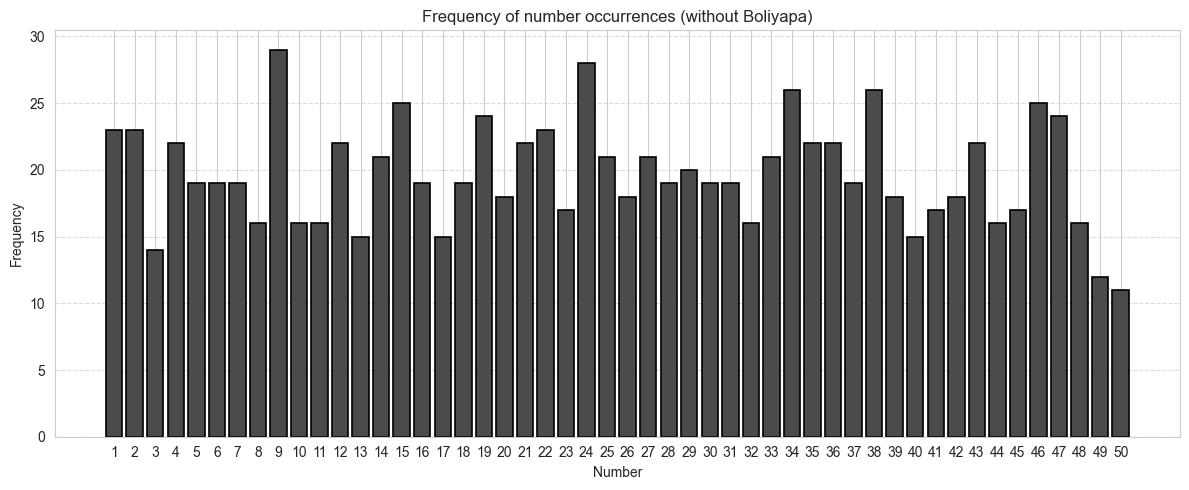

In [85]:
freq_table = analyze_number_frequency(df_tinka)

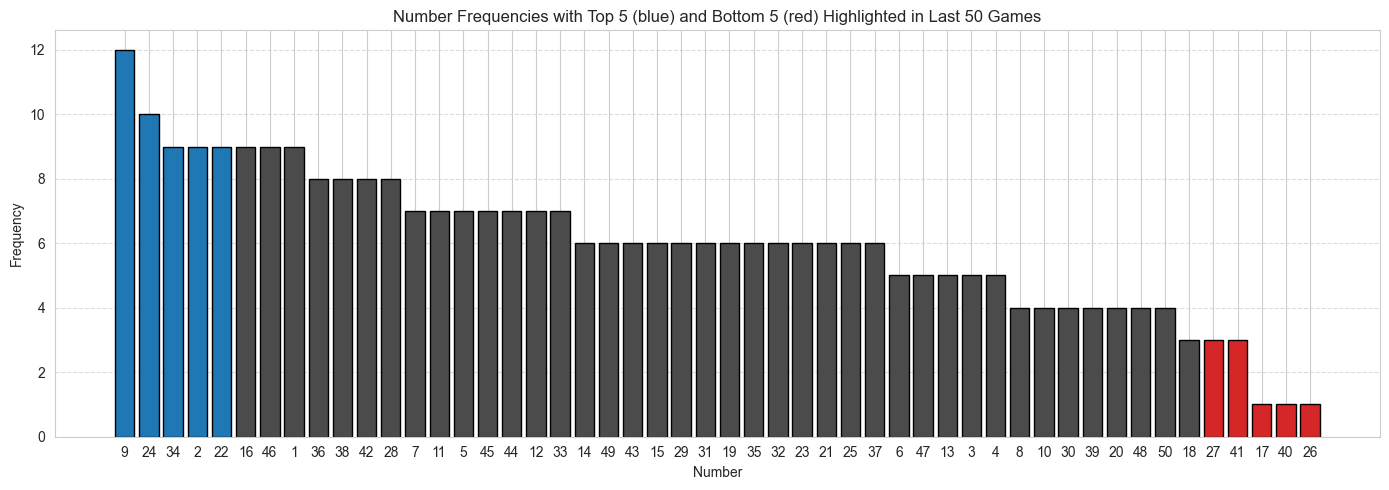

In [98]:
analyze_number_frequency_highlight(df_tinka, top_n=5, last_n_games=50)

- Los números que más aparecen en los últimos 50 juegos podría ser importante al momento de aplicar una regla.
- Evitar o considerar los números que menos aparecieron en los últimos 100 juegos podría ser importante también.
- Se tomará en cuenta ambos para considerar una regla a la hora de seleccionar los números ganadore y se les asignará un peso a cada uno para la selección.

---
### 2.2 Aparición de números pares e imapres

Se analiza la proporción de números **pares** e **impares** que han salido en los sorteos históricos de La Tinka.  

El objetivo es identificar patrones o tendencias en la distribución de números, por ejemplo, si es más común que salgan 3 pares y 3 impares, o si hay una ligera preferencia hacia uno de los dos tipos.

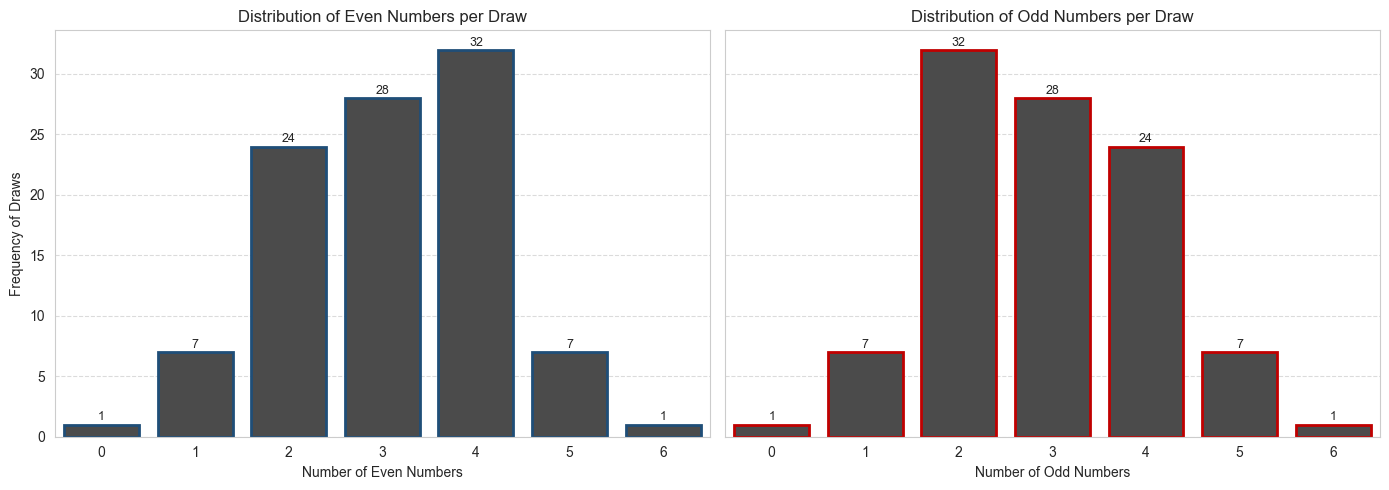

In [100]:
even_distribution = analyze_even_odd(df_tinka, last_n_games=100)

- En los últimos 100 juegos se ve que han aparecido más números pares que impares.
- Se dará un peso a la aparición de números pares de 2 a 4 al momento de seleccionar los números ganadores.

---
### 2.3 Proporción de números altos y bajos

Se analiza la proporción de números **bajos** y **altos** que han salido en los sorteos históricos de La Tinka.  

Se considera que un número es **bajo** si es menor o igual a 25 y **alto** si es mayor.  
El análisis busca identificar patrones, por ejemplo, si es más común que salgan 3 números bajos y 3 altos, o si existe una tendencia hacia un rango específico.

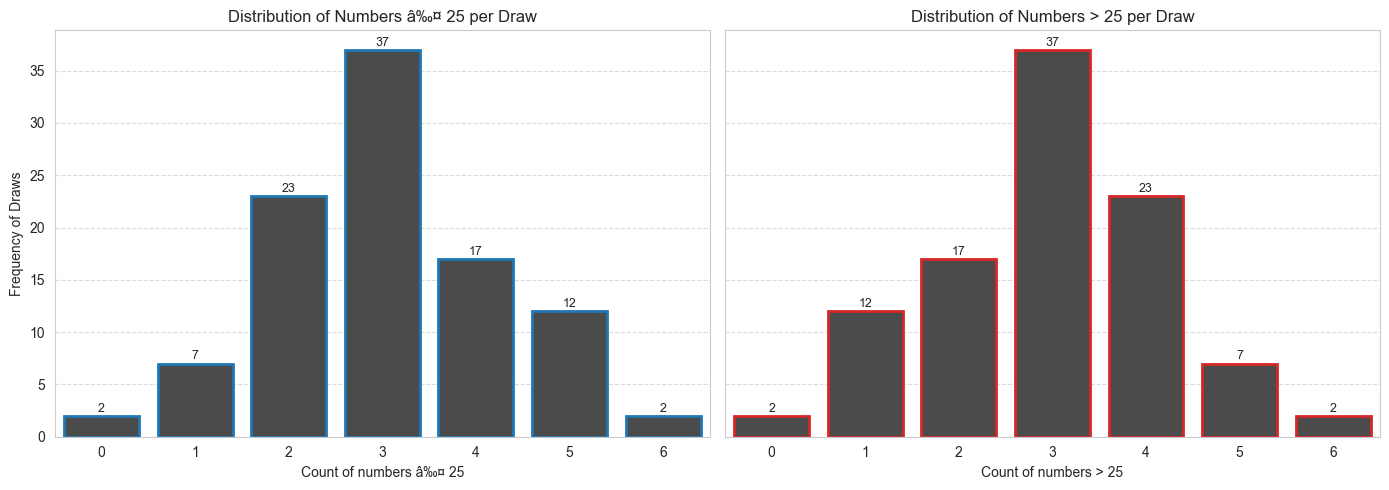

In [88]:
analyze_low_high(df_tinka, split_point=25, last_n_games=100)

- En los últimos 100 juegos hay una distribución normal para números que aparecen menor o mayor a 25.
- Se considerará una regla donde se espera que al menos hayan 3 números menores de 25 y 3 números mayores de 25. Se asignará un peso a cada aparición.

---
### 2.4 Números consecutivos

Se examina la presencia de **números consecutivos** en los sorteos históricos de La Tinka.  

El objetivo es determinar con qué frecuencia aparecen secuencias como (12, 13) o (28, 29) o incluso (3, 4, 5) dentro de un mismo sorteo.  
Este análisis ayuda a identificar si es común que se repitan patrones de números seguidos o si, por el contrario, los resultados tienden a estar más dispersos.

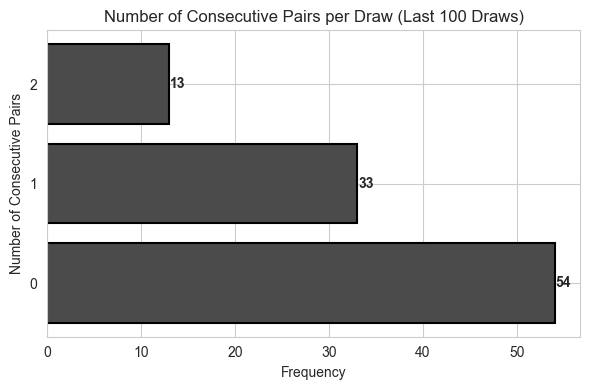

In [89]:
analyze_consecutive_numbers(df_tinka, last_n_games=100)

- Importante conocer que sí aparece una cantidad considerable de números consecutivos.
- En la regla se debe considerar como máximo 1 par de dos números consecutivos.

---
### 2.5 Transiciones entre números

Se analiza las **transiciones** entre números en los sorteos históricos de La Tinka.  

En este contexto, una transición ocurre cuando un número sorteado en un evento es seguido por otro número específico en un sorteo posterior.  
El análisis identifica cuáles son las transiciones más frecuentes y las muestra. 

**Ejemplo:**  
Si en un sorteo el número **7** apareció y en el siguiente sorteo apareció el número **23**, eso se registra como una transición **7 → 23**.  
Si esta misma transición ocurre muchas veces en la historia, aparecerá en las primeras posiciones del ranking.

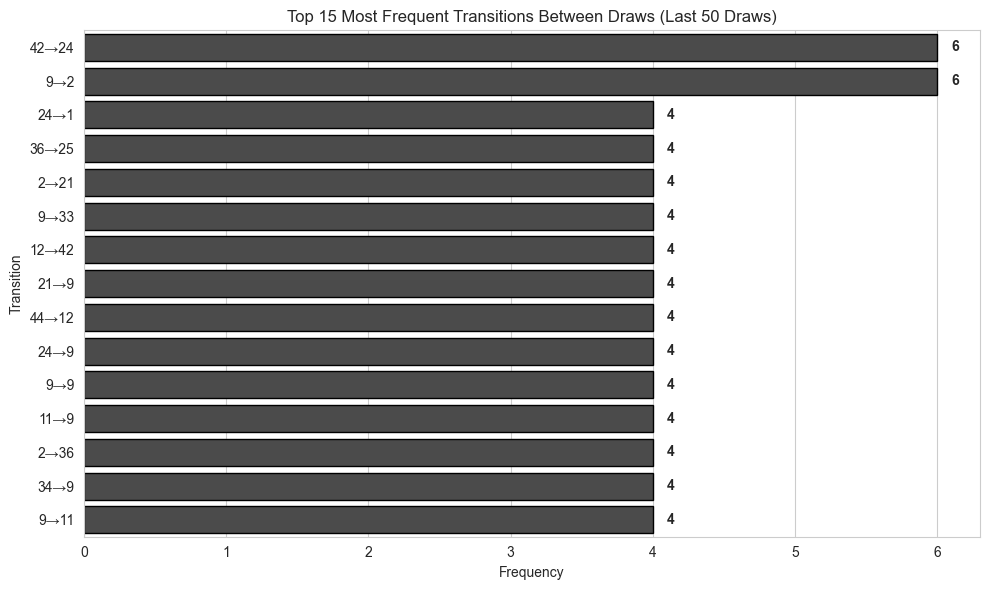

In [101]:
analyze_transitions(df_tinka, top_n=15, last_n_games=50)

- En este caso solo se tomará el top 1 para asignarle un peso adicional en la selección de números ganadores.

---
### 2.6 Frecuencia de números repetidos en sorteos consecutivos

Se estudia la frecuencia con la que se **repiten números** de un sorteo a otro en los resultados históricos de La Tinka.  

El objetivo es identificar cuántos números del sorteo anterior vuelven a aparecer en el siguiente y con qué frecuencia ocurre cada caso.  

**Ejemplo:**  
Si en un sorteo salen los números **[5, 12, 19, 28, 33, 45]** y en el siguiente sorteo los números son **[7, 12, 19, 25, 33, 48]**, entonces se han repetido **tres números**: 12, 19 y 33.  
El análisis muestra cuán habitual es que se repitan 0, 1, 2… o más números entre sorteos consecutivos.

Este tipo de información ayuda a entender si los sorteos suelen tener cierta continuidad o si, por lo general, los números cambian completamente.

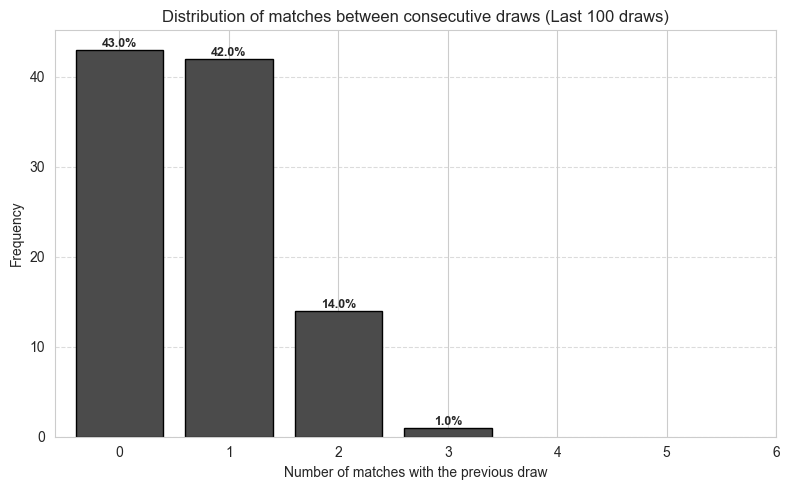

In [91]:
analyze_repeats(df_tinka, last_n_games=100)

- El peso de un número repetido en partidas continuas será igual que para números nuevos.

---
### 2.7 Análisis por Posición de Bola

En esta sección se examinan los números sorteados según su **posición** dentro del resultado oficial de La Tinka, desde la bola *B1* (la más baja) hasta la bola *B6* (la más alta).  

El objetivo es identificar patrones específicos en cada posición, como los rangos numéricos más comunes, los intervalos óptimos y la distribución histórica de valores.  
Para ello se utilizan tres análisis principales:

- Evaluación de los rangos de números que suelen aparecer en cada posición.
- Determinar los intervalos óptimos para cada posición según los datos históricos.
- Generar histogramas que muestran la frecuencia de aparición de cada número en cada posición.

Este enfoque ayuda a entender si ciertas posiciones tienden a contener números más bajos o más altos, y si existe una distribución consistente a lo largo del tiempo.

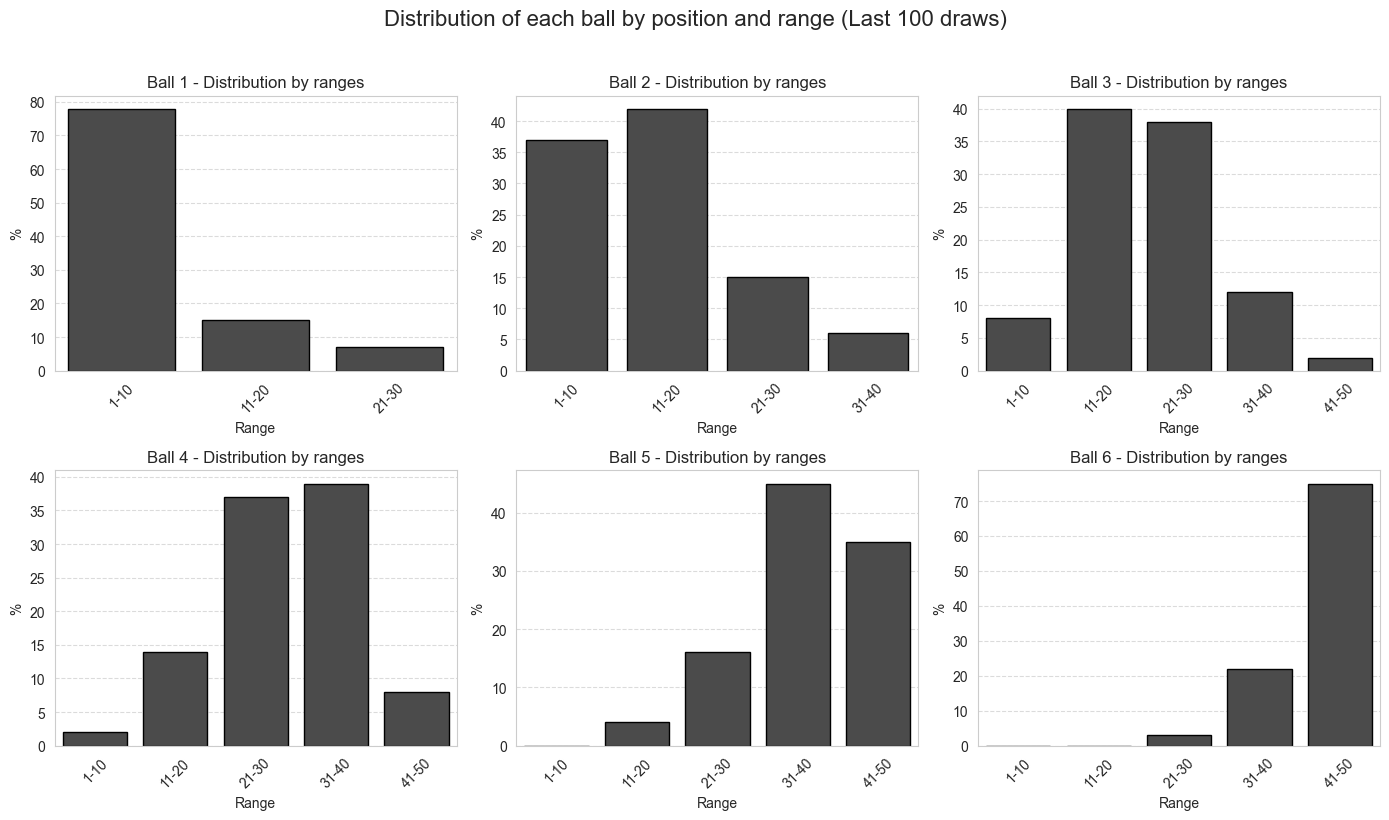

In [92]:
analyze_ball_position_ranges(df_tinka, last_n_games=100)

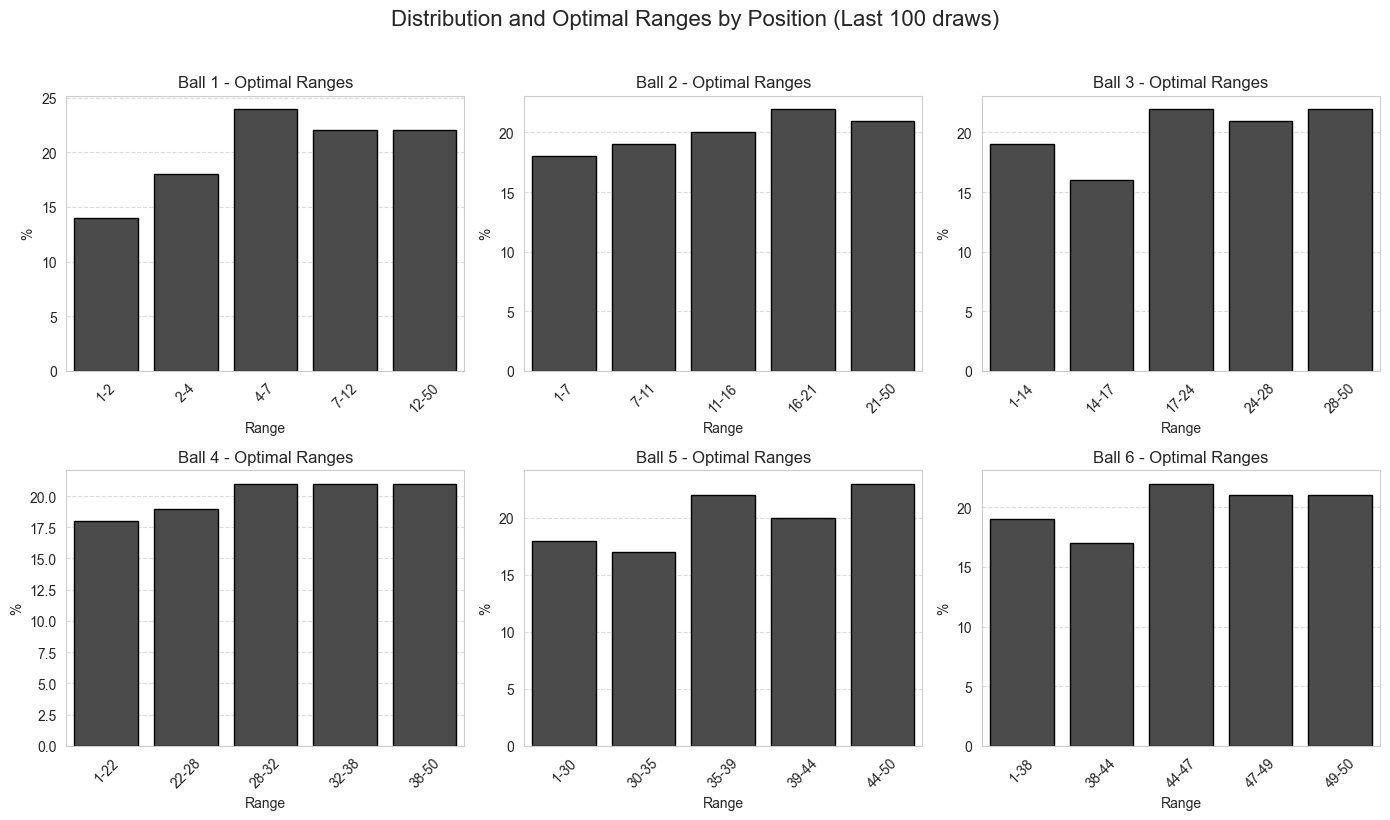

In [93]:
analyze_optimal_ranges_per_position(df_tinka, last_n_games=100)

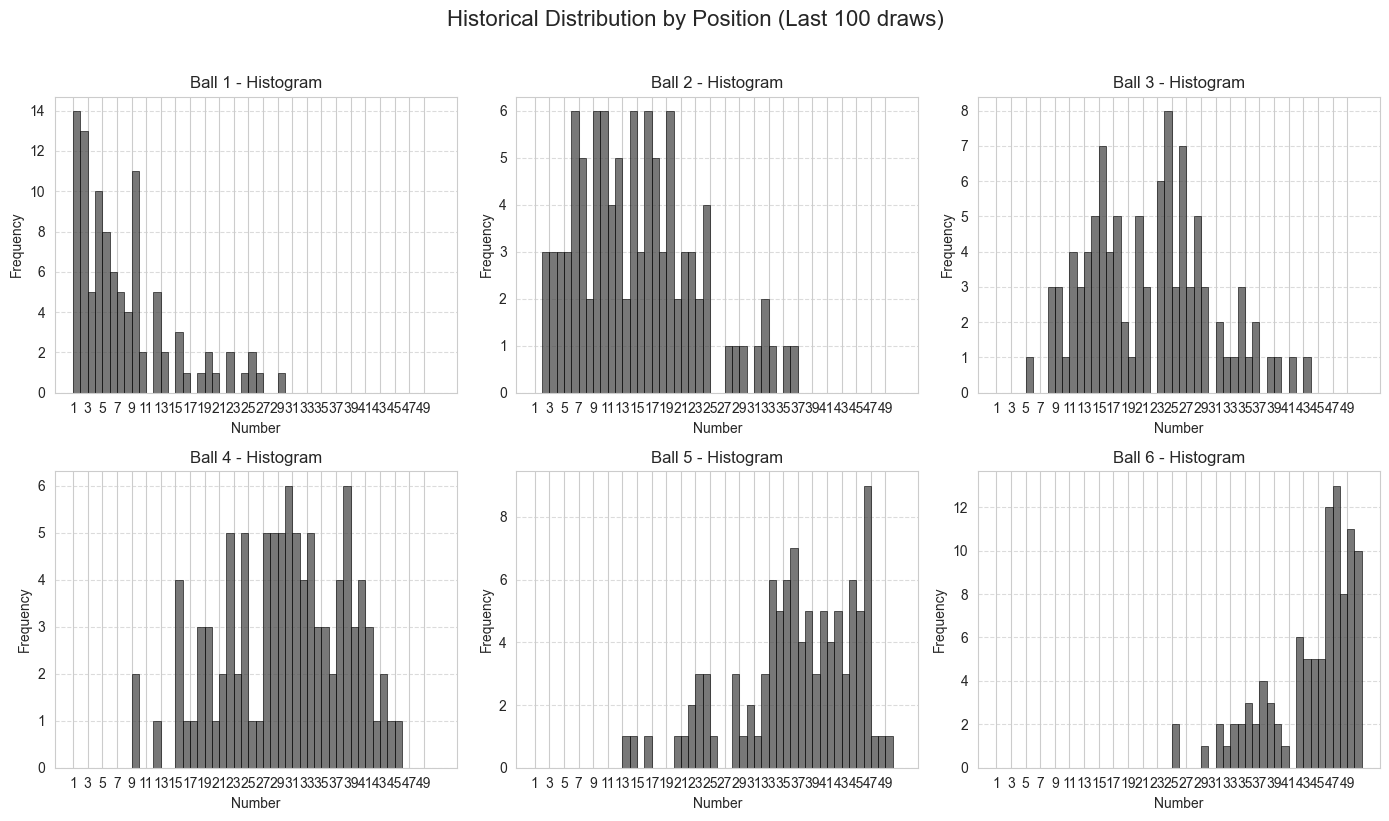

In [94]:
plot_histograms_per_position(df_tinka, last_n_games=100)